## Create a synthetic dataset

## K-Means VS. Agglomerative Hierarcichal Clustering VS. DBSCAN VS. GMM

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Cleaned_Data_Merchant_Name.csv')
df

,Trx_Rank,Points,Trx_Vlu,Trx_Age,Customer_Age,Category In English,User_Id,Mer_Name
0,1,20140,2014.0,362,362,Fashion,21053,Shankar Traders
1,1,11200,1120.0,371,368,Fashion,26472,Shankar Traders
2,2,8500,850.0,368,368,Fashion,26472,Shankar Traders
3,1,1980,198.0,558,34,Fashion,27075,Shankar Traders
4,1,2400,240.0,413,413,Fashion,27417,Shankar Traders
...,...,...,...,...,...,...,...,...
43667,1,3050,305.0,27,27,F&B,26865,Cuttack Curtain Corner
43668,1,3120,312.0,31,31,F&B,27128,Cuttack Curtain Corner
43669,1,1200,120.0,25,25,F&B,28814,Cuttack Curtain Corner
43670,1,20,2.0,2,2,Other,29107,Rourkela Rice Retail


In [4]:
# Assuming 'Trx_Age' is the number of days
reference_date = pd.to_datetime('2022-01-01')  # Choose a suitable reference date

# Convert 'Trx_Age' to datetime format by adding it to the reference date
df['Trx_Age'] = reference_date + pd.to_timedelta(df['Trx_Age'], unit='D')

In [5]:
import datetime as dt
snapshot_date = max(df.Trx_Age) + dt.timedelta(days=1)

In [6]:
# RFM table
# Aggregate data by each customer
rfm = df.groupby('User_Id').agg({'Trx_Age': lambda x: (snapshot_date - x.max()).days, 'Trx_Rank': lambda x: len(x), 'Trx_Vlu': lambda x: x.sum()}).reset_index()
rfm['Trx_Age'] = rfm['Trx_Age'].astype(int)

# Rename columns
rfm.rename(columns={'Trx_Age': 'Recency',
                         'Trx_Rank': 'Frequency',
                         'Trx_Vlu': 'MonetaryValue'}, inplace=True)

In [7]:
# Set the Numbers
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(rfm['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(rfm['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
33452,306.059802,0.179544,8.406118
33453,321.981083,0.000000,3.634241
33454,314.027705,0.000000,5.091643
33455,472.708543,0.000000,5.943922
33456,183.734936,0.179544,8.281635


In [8]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[-0. -0.  0.]
[1. 1. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


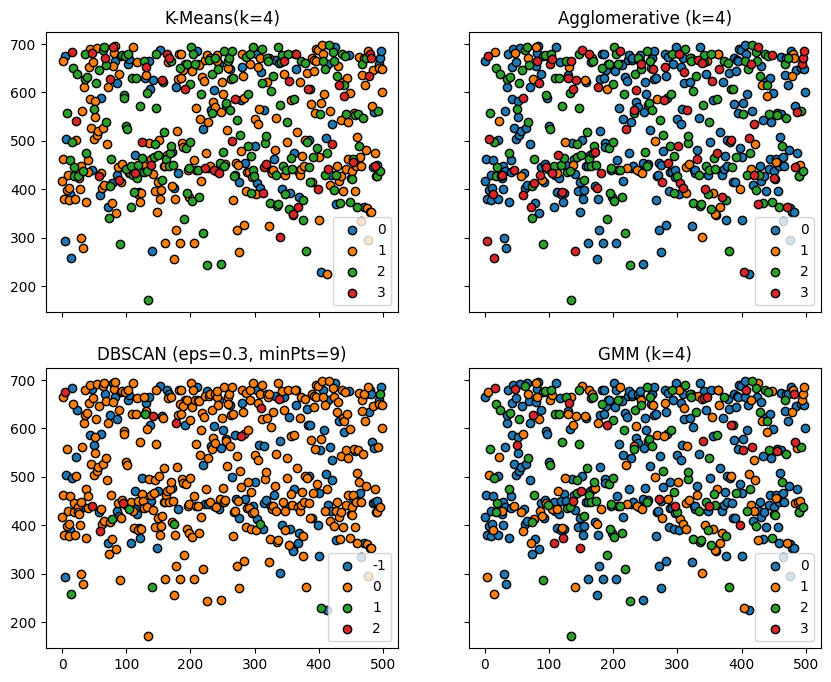

In [10]:
from itertools import product

from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot


# define the models
model1 = KMeans(n_clusters=4)
model2 = AgglomerativeClustering(n_clusters=4)
model3 = DBSCAN(eps=0.3, min_samples=9)
model4 = GaussianMixture(n_components=4)

import numpy as np

# Assuming 'customers_normalized' is a NumPy array
random_indices = np.random.choice(customers_normalized.shape[0], size=500, replace=False)
random_sample = customers_normalized[random_indices]

# assign a cluster to each example
yhat_kmeans = model1.fit_predict(random_sample)
yhat_agg = model2.fit_predict(random_sample)
yhat_dbscan = model3.fit_predict(random_sample)
yhat_gmm = model4.fit_predict(random_sample)

# retrieve unique clusters
clusters = unique([yhat_kmeans]+[yhat_agg]+[yhat_dbscan]+[yhat_gmm])


# create subplots
f, axarr = pyplot.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

# create scatter plot for samples from each cluster for each model
# create scatter plot for samples from each cluster for each model
for cluster in clusters:
    for idx, yhat, title in zip(product([0, 1], [0, 1]),
                        [yhat_kmeans, yhat_agg, yhat_dbscan, yhat_gmm],
                        ['K-Means(k=4)', 'Agglomerative (k=4)',
                         'DBSCAN (eps=0.3, minPts=9)', 'GMM (k=4)']):
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        if len(row_ix[0]):
            # create scatter of these samples
            axarr[idx[0], idx[1]].scatter(rfm.iloc[row_ix[0], 0], rfm.iloc[row_ix[0], 1], edgecolor='k', label=cluster)
            # set titles
            axarr[idx[0], idx[1]].set_title(title)
            # add legend
            axarr[idx[0], idx[1]].legend()

# show the plot
pyplot.show()



In [10]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=2)
model.fit(customers_normalized)
bic = model.bic(customers_normalized)
aic = model.aic(customers_normalized)
print(f"BIC: {bic}, AIC: {aic}")


BIC: -146545.64551360396, AIC: -146705.58782351727


In [15]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from numpy import unique, where
from itertools import product
from matplotlib import pyplot

# Assuming 'rfm' is your data
# ...

# define the models
from sklearn.cluster import DBSCAN

model1 = KMeans(n_clusters=4)
model2 = AgglomerativeClustering(n_clusters=4)
model3 = DBSCAN(eps=0.3, min_samples=9)
model4 = GaussianMixture(n_components=4)

# Fit the models
model1.fit(customers_normalized)
model2.fit(customers_normalized)
yhat_dbs = model3.fit_predict(customers_normalized)  # Corrected: use fit_predict instead of fit.predict
model4.fit(customers_normalized)

# Calculate inertia for KMeans and Agglomerative clustering
inertia_kmeans = model1.inertia_

from sklearn.metrics import silhouette_score

# Predict clusters
yhat_agg = model2.labels_
yhat_gmm = model4.predict(customers_normalized)

# Calculate silhouette score
silhouette_avg_1 = silhouette_score(customers_normalized, yhat_agg)
silhouette_avg_2 = silhouette_score(customers_normalized, yhat_gmm)
silhouette_avg_3 = silhouette_score(customers_normalized, yhat_dbs)
print(f"Agglomerative Clustering Silhouette Score: {silhouette_avg_1}")
print("*" * 50)
print(f"Agglomerative Clustering Silhouette Score: {silhouette_avg_2}")
print("*" * 50)
print(f"Agglomerative Clustering Silhouette Score: {silhouette_avg_3}")
print("*" * 50)


# Print inertia values
print(f"KMeans Inertia = {inertia_kmeans}")

# Other clustering models (DBSCAN and Gaussian Mixture) don't have inertia

# ...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Agglomerative Clustering Silhouette Score: 0.48879720791256726
**************************************************
Agglomerative Clustering Silhouette Score: 0.4289350504342071
**************************************************
Agglomerative Clustering Silhouette Score: 0.5426496134383231
**************************************************
KMeans Inertia = 25491.74479182496


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

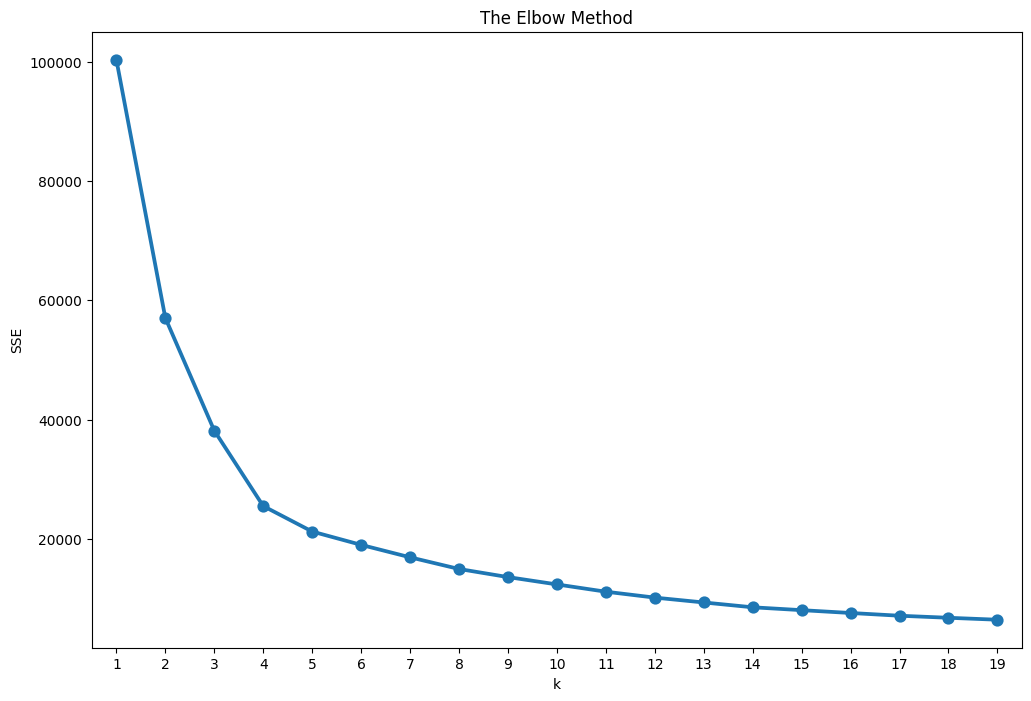

In [16]:
plt.figure(figsize=(12,8))

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)

    distortions.append(sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / customers_normalized.shape[0])
    inertias.append(kmeans.inertia_)

    mapping1[k] = sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / customers_normalized.shape[0]

    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [17]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 1.5174314280757282
2 : 1.1252730972030487
3 : 0.8100418612236522
4 : 0.7017433879231908
5 : 0.6489406696436544
6 : 0.6016504583509682
7 : 0.5629382672629465
8 : 0.5379156798658801
9 : 0.5082464813489447
10 : 0.46817105046142177
11 : 0.4616813770107377
12 : 0.4442696916388927
13 : 0.4292596740642815
14 : 0.4139027635203329
15 : 0.4004262978494071
16 : 0.39293011788526566
17 : 0.3802471530503681
18 : 0.3668998250952824
19 : 0.36207003299005014


In [18]:
from sklearn.preprocessing import normalize
data_scaled = normalize(customers_fix)
data_scaled = pd.DataFrame(data_scaled, columns=customers_fix.columns)
data_scaled

,Recency,Frequency,MonetaryValue
0,0.999672,0.000000,0.025618
1,0.999906,0.000000,0.013700
2,0.999791,0.000000,0.020450
3,0.999798,0.000000,0.020085
4,0.999812,0.000000,0.019387
...,...,...,...
33452,0.999623,0.000586,0.027455
33453,0.999936,0.000000,0.011286
33454,0.999869,0.000000,0.016212
33455,0.999921,0.000000,0.012573


In [19]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(33457,)

In [20]:
# The lowest SSE value
print(f"Inertia = {kmeans.inertia_}")

# Final locations of the centroid
print(f"Cluster centers are: {kmeans.cluster_centers_}")

# The number of iterations required to converge
print(f"The number of iterations until convergence is {kmeans.n_iter_} iterations")

Inertia = 6421.59120769109
Cluster centers are: [[ 0.73998932  2.0440514   0.06170286]
 [-0.38442589 -0.48674791 -0.34715167]
 [ 1.25195511 -0.48674791 -0.80299401]
 [ 1.07043641 -0.48674791  2.42538854]
 [-1.87917294  2.05922473  0.18847313]
 [-1.13682416  2.06793529  2.74293781]
 [ 1.1734138  -0.48674791  0.64130112]
 [-0.86985354 -0.48674791  2.73308923]
 [-1.86343132 -0.48674791 -0.61392695]
 [ 0.44228636 -0.48674791 -0.33953213]
 [-1.2466933   2.08997944  9.97133463]
 [-0.66104402  2.04645331 -0.21927802]
 [-0.47597586 -0.48674791 -0.92436339]
 [-0.68015772  2.05448386  0.85356057]
 [-0.96782992  2.05896211  4.47853808]
 [-0.97310648 -0.48674791 -0.46404579]
 [ 1.31121085 -0.48674791 -0.19116505]
 [ 0.64620631  2.05294533  2.29134937]
 [-0.3991967  -0.48674791  0.48527566]]
The number of iterations until convergence is 30 iterations


In [21]:
rfm.shape

(33457, 4)

In [22]:
rfm["Cluster"] = model.labels_
rfm.head()

,User_Id,Recency,Frequency,MonetaryValue,Cluster
0,0,418,1,442.7,2
1,1,665,1,249.0,0
2,2,463,1,300.0,2
3,3,379,1,162.0,2
4,4,292,1,70.0,2


In [23]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0         633.7       1.0         287.2  12203
1         408.8       2.4         401.5   5153
2         431.2       1.0         201.0  13888
3         426.3       2.3        2756.3   2213

In [24]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

rfm["Cluster"] = model.labels_
rfm.head()
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0         633.7       1.0         287.2  12203
1         408.8       2.4         401.5   5153
2         431.2       1.0         201.0  13888
3         426.3       2.3        2756.3   2213

In [25]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,-0.683050,-0.486748,0.427948,0,2
1,1.345509,-0.486748,-0.142321,1,0
2,-0.308526,-0.486748,0.030502,2,2
3,-1.009835,-0.486748,-0.502355,3,2
4,-1.747442,-0.486748,-1.072556,4,2


In [26]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,2,Recency,-0.683050
1,1,0,Recency,1.345509
2,2,2,Recency,-0.308526
3,3,2,Recency,-1.009835
4,4,2,Recency,-1.747442


In [27]:
df_nor_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100371 entries, 0 to 100370
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         100371 non-null  int64  
 1   Cluster    100371 non-null  int32  
 2   Attribute  100371 non-null  object 
 3   Value      100371 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 2.7+ MB


In [28]:
# Aggregate data by each customer
fig3 = df_nor_melt.groupby('Cluster').agg({'ID': lambda x: len(x)}).reset_index()


# Rename columns
fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Cluster,Count,percent
0,0,36609,36.5
1,1,15459,15.4
2,2,41664,41.5
3,3,6639,6.6


In [29]:
#Creating a Treemap with Plotly Express
# colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c'] #color palette
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px

fig = px.treemap(fig3, path=['Cluster'],values='Count'
                 , width=800, height=400
                 ,title="Distribution of Cluster")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [30]:
df_nor_melt

,ID,Cluster,Attribute,Value
0,0,2,Recency,-0.683050
1,1,0,Recency,1.345509
2,2,2,Recency,-0.308526
3,3,2,Recency,-1.009835
4,4,2,Recency,-1.747442
...,...,...,...,...
100366,33452,1,MonetaryValue,0.764342
100367,33453,2,MonetaryValue,-1.281350
100368,33454,2,MonetaryValue,-0.656566
100369,33455,0,MonetaryValue,-0.291196


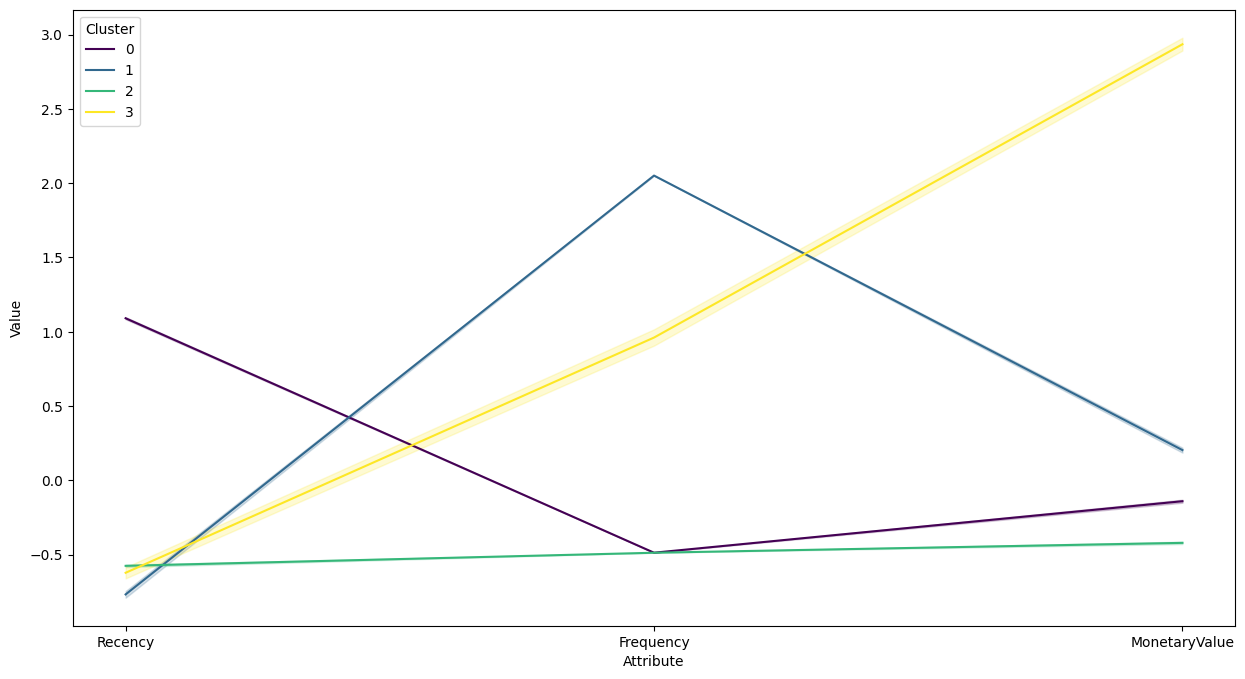

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_nor_melt has columns 'Attribute,' 'Value,' and 'Cluster.'

# Set the figure size
plt.figure(figsize=(15, 8))

# Seaborn line plot with increased size
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt, palette='viridis')

# Show the plot
plt.show()


In [32]:
import pandas as pd
from tabulate import tabulate

# Assuming you have a DataFrame named 'cluster_summary' with the required information
cluster_summary = pd.DataFrame({
    'Cluster': [0, 1, 2, 3],
    'Type of customers': ['Lost customers/churned customers', 'New customers', 'At risk customers', 'Loyal customers'],
    '%': [36, 15, 41, 6],
    'RFM Interpretation': [
        'Customers who made their last transaction a long time ago,'
        'and who have made few purchases. Therefore, it could be the'
        'cluster of Lost customer/churned customers.',
        "Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending.",
        "Customer who made their last transaction a while ago and who made frequent and large purchases in the past.",
        "Most frequent customers with the highest monetary spending amount and transact most recently"
    ]
})
# Display the DataFrame with increased font size
cluster_summary.style.set_properties(**{'font-size': '10pt'})

,Cluster,Type of customers,%,RFM Interpretation
0,0,Lost customers/churned customers,36,"Customers who made their last transaction a long time ago,and who have made few purchases. Therefore, it could be thecluster of Lost customer/churned customers."
1,1,New customers,15,"Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending."
2,2,At risk customers,41,Customer who made their last transaction a while ago and who made frequent and large purchases in the past.
3,3,Loyal customers,6,Most frequent customers with the highest monetary spending amount and transact most recently


In [33]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0         633.7       1.0         287.2  12203
1         408.8       2.4         401.5   5153
2         431.2       1.0         201.0  13888
3         426.3       2.3        2756.3   2213

In [34]:
cluster_avg = rfm.groupby('Cluster').mean()
population_avg = rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,Frequency,MonetaryValue,Recency,User_Id
Cluster,,,,,
0,NaN,-0.233840,-0.335633,0.264178,-0.068074
1,NaN,0.849605,-0.071404,-0.184593,0.115825
2,NaN,-0.233903,-0.535101,-0.139778,-0.012480
3,NaN,0.779021,5.375125,-0.149715,0.183997


In [35]:
rfm_fig = rfm.copy()

#Remove the outlier for visualization
y1 = rfm_fig['Frequency']
size = rfm_fig.shape[0]
removed_outliers = y1.between(y1.quantile(.05), y1.quantile(.95))
print(str(y1[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = rfm_fig[~removed_outliers].index
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y2 = rfm_fig['Recency']
size = rfm_fig.shape[0]
removed_outliers = y2.between(y2.quantile(.05), y2.quantile(.95))
print(str(y2[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = rfm_fig[~removed_outliers].index
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y3 = rfm_fig['MonetaryValue']
size = rfm_fig.shape[0]
removed_outliers = y3.between(y3.quantile(.05), y3.quantile(.95))
print(str(y3[removed_outliers].size) + "/" + str(size) + " data points remain.")
index_names = rfm_fig[~removed_outliers].index
rfm_fig.drop(index_names, inplace=True)

32637/33457 data points remain.
29412/32637 data points remain.
26526/29412 data points remain.
